# Exploratory Data Analysis
---
#### Import libraries and read data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import re
from sklearn.pipeline import Pipeline
import pickle
from scipy.stats import ttest_ind
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../data/cleaned_skincare.csv')
df.dropna(inplace=True)

df.head(2)

,author,title,selftext,num_comments,score,subreddit,is_ab
0,lululi_lululi,working seasoned estheticians hundreds consult...,project glowism https glowism friend female en...,4,1,asianbeauty,1
1,BasicBake,wash water,hello wondering wash water usually refrained w...,8,2,asianbeauty,1


## Explore distribution of numeric features
---

#### Summary statistics on numeric features

Both subreddits have greater mean than median for `num_comments` and `score`. Which means, most values for the two features are clustered around the left tail of the distribution with few high values.

To expand, on average, `AsianBeauty` subreddit has 6x more comments and 21x higher scores per post than `SkincareAddiction`.

While higher comments per post insinuates a more active community, a higher score can mean a few things about a subreddit. First, let's explore how a submission's score is determined,
>A submission's score is simply the number of upvotes minus the number of downvotes. If five users like the submission and three users don't it will have a score of 2.

[Source: Reddit FAQ](https://www.reddit.com/wiki/faq#wiki_how_is_a_submission.27s_score_determined.3F)

With Reddit's scoring in mind, it is important to note that **post scores does not hint at the communities' activity or responsiveness** because this might mean mean that the `AsianBeauty` community often upvotes and rarely downvotes, or the `SkincareAddiction` community is more assertive in upvoting and downvoting. In the two scenarios mentioned, one subreddit can be just as active as the other.

In [3]:
round(df.drop(columns='is_ab').groupby('subreddit').describe().T,2)

subreddit           asianbeauty  skincareaddiction
num_comments count      8771.00            8887.00
             mean         28.71               6.79
             std          45.26              16.54
             min           0.00               0.00
             25%           2.00               1.50
             50%          14.00               4.00
             75%          36.00               8.00
             max         868.00             546.00
score        count      8771.00            8887.00
             mean         30.60               1.16
             std          64.48               2.86
             min           0.00               0.00
             25%           1.00               1.00
             50%          10.00               1.00
             75%          32.00               1.00
             max        1250.00             175.00

#### Plot the distribution of `num_comments`

As implied by the greater mean than median from the summary statistics above, we expect outliers on the right tail and have more observations with low values of `num_comments`. Hence, I'm only looking at the distribution of `num_comments` where approx. 75% of our data lies.

The histogram below emphasizes how the majority of posts in SkincareAddiction subreddit have less than 10 comments and the distribution of scores in AsianBeauty is more varied.

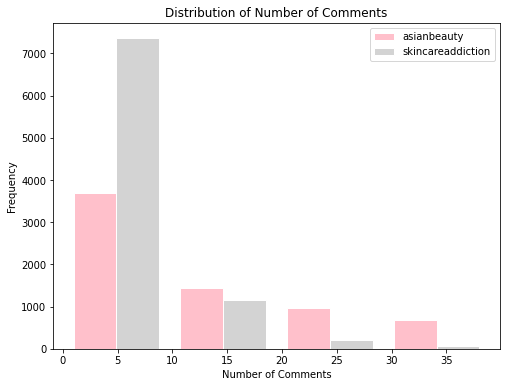

In [4]:
plt.figure(figsize=(8,6))
plt.hist([df[(df['is_ab']==1) & (df['num_comments'] < 40)]['num_comments'],
          df[(df['is_ab']==0) & (df['num_comments'] < 40)]['num_comments']],
         bins=4,
         color=['pink', 'lightgrey'],
         ec='w')

plt.title('Distribution of Number of Comments', fontsize=12)
plt.xlabel('Number of Comments')
plt.ylabel('Frequency')
plt.legend(['asianbeauty', 'skincareaddiction']);

# Daniel Kim

#### Plot the distribution of `score`

I'm also only looking at the distribution of `score` where approx. 75% of our data lies. Shown on the histogram below how the majority of posts in SkincareAddiction subreddit have less than 10 scores and the distribution of scores in AsianBeauty is more varied.

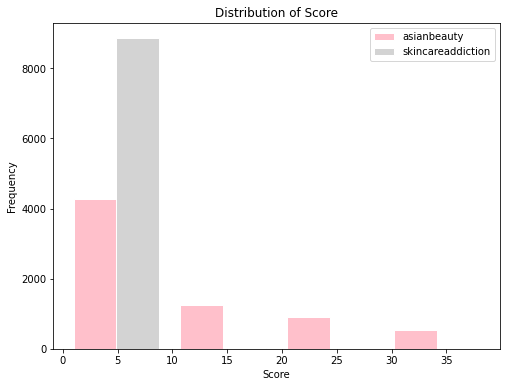

In [5]:
plt.figure(figsize=(8,6))
plt.hist([df[(df['is_ab']==1) & (df['score'] < 40)]['score'],
          df[(df['is_ab']==0) & (df['score'] < 40)]['score']],
         bins=4,
         color=['pink', 'lightgrey'],
         ec='w')

plt.title('Distribution of Score', fontsize=12)
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.legend(['asianbeauty', 'skincareaddiction']);

# Daniel Kim

## Explore length of post `title`
---

##### Count words and characters in `title`s

In [6]:
df['title_word_count'] = df['title'].apply(lambda x: x.count(' '))

df['title_char_count'] = df['title'].apply(lambda x : len(x))

##### Plot word and character length in `title`s

The majority of titles are less than 10 words, or 50 characters. For comparison, these titles are generally as short as short as,
>The quick brown fox jumps over the lazy dog.

(9 words, 43 characters)

Which is generally enough words in a title to describe the post.

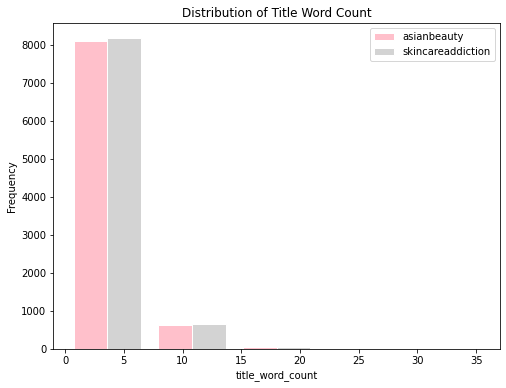

In [7]:
plt.figure(figsize=(8,6))
plt.hist([df[df['is_ab']==1]['title_word_count'],
          df[df['is_ab']==0]['title_word_count']],
         bins=5,
         color=['pink', 'lightgrey'],
         ec='w')

plt.title('Distribution of Title Word Count', fontsize=12)
plt.xlabel('title_word_count')
plt.ylabel('Frequency')
plt.legend(['asianbeauty', 'skincareaddiction']);

# Daniel Kim

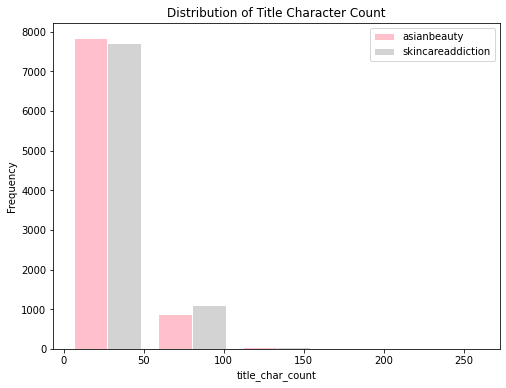

In [8]:
plt.figure(figsize=(8,6))
plt.hist([df[df['is_ab']==1]['title_char_count'],
          df[df['is_ab']==0]['title_char_count']],
         bins=5,
         color=['pink', 'lightgrey'],
         ec='w')

plt.title('Distribution of Title Character Count', fontsize=12)
plt.xlabel('title_char_count')
plt.ylabel('Frequency')
plt.legend(['asianbeauty', 'skincareaddiction']);

# Daniel Kim

## Explore length of post `selftext`
---
##### Count words and characters in `selftext`

In [9]:
df['selftext_word_count'] = df['selftext'].apply(lambda x: str(x).count(' '))

df['selftext_char_count'] = df['selftext'].apply(lambda x : len(str(x)))

##### Plot word and character length in `selftext`

The majority of selftext are less than 200 words, or 1000 characters. These would convert to about 0.7 minutes of reading ([source](https://capitalizemytitle.com/reading-time/200-words/)).

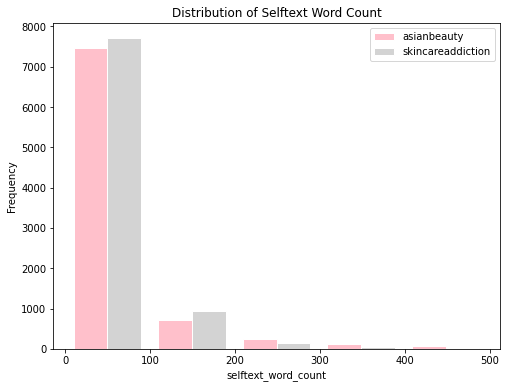

In [10]:
plt.figure(figsize=(8,6))
plt.hist([df[(df['is_ab']==1) & (df['selftext_word_count']<500)]['selftext_word_count'],
          df[(df['is_ab']==0) & (df['selftext_word_count']<500)]['selftext_word_count']],
         bins=5,
         color=['pink', 'lightgrey'],
         ec='w')

plt.title('Distribution of Selftext Word Count', fontsize=12)
plt.xlabel('selftext_word_count')
plt.ylabel('Frequency')
plt.legend(['asianbeauty', 'skincareaddiction']);

# Daniel Kim

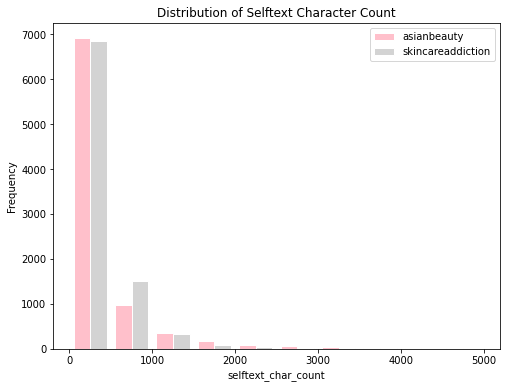

In [11]:
plt.figure(figsize=(8,6))
plt.hist([df[(df['is_ab']==1) & (df['selftext_char_count']<5000)]['selftext_char_count'],
          df[(df['is_ab']==0) & (df['selftext_char_count']<5000)]['selftext_char_count']],
         bins=10,
         color=['pink', 'lightgrey'],
         ec='w')

plt.title('Distribution of Selftext Character Count', fontsize=12)
plt.xlabel('selftext_char_count')
plt.ylabel('Frequency')
plt.legend(['asianbeauty', 'skincareaddiction']);

# Daniel Kim

## Explore correlations between numeric features
---
I assumed that shorter titles and selftexts might represent skincare questions and concerns that lead to more engagement from the community (higher `num_comments`) to share their experiences or thoughts. Yet, the correlation heatmap below shows that the correlation between`title` or `selftext` length and `num_comments` are all less than 0.1 (weak).

However, I found that the `score` is indeed positively correlated (.52) to `num_comments` which is an indicator of community activity. We can conclude that active subreddits have high scores and number of comments. However, the correlation does not equate to causation.

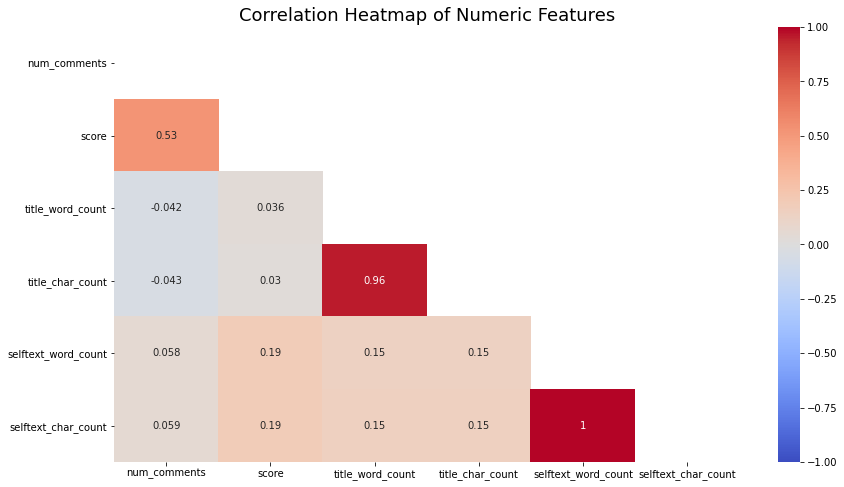

In [12]:
plt.figure(figsize=(14,8))

sns.heatmap(df.drop(columns = 'is_ab').corr(), mask=np.triu(df.drop(columns = 'is_ab').corr()), annot=True, cmap='coolwarm', vmin=-1, vmax=1)

locs, labels = plt.xticks()
plt.setp(labels, rotation=0)

locs, labels = plt.yticks()
plt.setp(labels, rotation=0)

plt.title('Correlation Heatmap of Numeric Features',  fontsize = 18);

## Explore words used in subreddits
---


### Combine text data

In [13]:
df['combined_text'] = df['title'] + ' ' + df['selftext']

### Vectorize text data

In [14]:
custom_stopwords = pickle.load(open('../assets/custom_stopwords.pkl', 'rb'))

cvec = CountVectorizer(stop_words=custom_stopwords, min_df=5, max_df=.8, max_features=200)

cvec_text = cvec.fit_transform(df['combined_text'])

text_features = cvec.get_feature_names()

feat_to_drop = []

for i in text_features:
    if re.match('[0-9]\S+', i):
        feat_to_drop.append(i)
        
text_df = pd.DataFrame(cvec_text.toarray(), columns=cvec.get_feature_names())

text_df.drop(columns= feat_to_drop, inplace = True)
text_df.head(2)

,acid,acne,actually,add,advice,aging,ago,aha,amazon,anti,...,week,weeks,went,white,wondering,work,works,year,years,zinc
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,2,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,2,0,0,0,1,0


##### Check the top 20 most frequent words in AsianBeauty subreddit

In [15]:
is_ab = df['is_ab']

text_df.insert(0, 'is_ab', is_ab)

In [16]:
round(text_df.groupby('is_ab').sum().T.sort_values(1, ascending=False),2).head(20)

is_ab,0.0,1.0
https,2618,4066
mask,1297,3555
cream,3095,3397
oil,3326,2713
good,2105,2670
skincare,2478,2653
time,2319,2414
sunscreen,2208,2343
new,1688,2263
masks,393,2168


##### Check the top 20 most frequent words in SkincareAddiction subreddit

In [17]:
round(text_df.groupby('is_ab').sum().T.sort_values(0, ascending=False),2).head(20)

is_ab,0.0,1.0
acne,6930,2087
cleanser,3925,1731
acid,3721,1234
dry,3336,2095
oil,3326,2713
moisturizer,3222,973
cream,3095,3397
https,2618,4066
skincare,2478,2653
cerave,2386,317


##### Check if there are overlapping frequent words

In [18]:
top_words_azn = list(text_df.groupby('is_ab').
     mean().T.sort_values(1, ascending=False).head(50).index)

top_words_skin = list(text_df.groupby('is_ab').
     mean().T.sort_values(0, ascending=False).head(50).index)

In [19]:
top_words_overlap = [i for i in top_words_azn if i in top_words_skin]
top_words_overlap

['https',
 'mask',
 'cream',
 'oil',
 'good',
 'skincare',
 'time',
 'sunscreen',
 'new',
 'dry',
 'acne',
 'think',
 'used',
 'water',
 'day',
 'cleanser',
 'want',
 'feel',
 'toner',
 'make',
 'gel',
 'lot',
 'looking',
 'serum',
 'got',
 'acid',
 'need']

##### Check differentiating words (not overlapping)
Differentiating words **might** be the keywords that help my model make accurate predictions.

In [20]:
# AsianBeauty
top_words_differ = [i for i in top_words_azn if i not in top_words_skin]
top_words_differ

['masks',
 'essence',
 'makeup',
 'review',
 'love',
 'cosrx',
 'sheet',
 'ingredients',
 'people',
 'best',
 'reddit',
 'cleansing',
 'look',
 'try',
 'asianbeauty',
 'extract',
 'comments',
 'snail',
 'long',
 'hair',
 'pretty',
 'little',
 'amazon']

In [21]:
# SkincareAddiction
top_words_differ1 = [i for i in top_words_skin if i not in top_words_azn]
top_words_differ1

['moisturizer',
 'cerave',
 'oily',
 'question',
 'ordinary',
 'night',
 'wash',
 'pm',
 'started',
 'week',
 'vitamin',
 'spf',
 'sensitive',
 'red',
 'years',
 'sure',
 'months',
 'facial',
 'niacinamide',
 'concerns',
 'thanks',
 'morning',
 'lotion']

##### Hypothesis test overlapping words with alpha = .05

>𝐻0: The subreddits for shoes and socks have the same mean frequency for word $x$.

>𝐻𝐴: The subreddits for shoes and socks have a different mean frequency for word $x$.

The words with P-value less than alpha have statistically significant mean frequency in the 2 subreddits. These might also be the keywords that helps us predict their classes when modeling. Moreover, the bar chart (see codes below) helps us visualize the direction of the T-tests. This indicates which subreddit the keyword might be useful in predicting.

The most valuable insights from this hypothesis testing is that there are different sets of frequent words in each subreddit that might help us build an accurate model. 

To summarize, besides the differentiating keywords (not overlapping), the statistically significant frequent overlapping words also alludes that each subreddit discusses the following topics more often than the other:

| Subreddit         | Topics of Discussion                                             |
|-------------------|------------------------------------------------------------------|
| AsianBeauty       | Oily (skin), acids, serums, gels, toners                         |
| SkincareAddiction | Makeup, acne, dry (skin), sunscreen, (face) oils, AM/PM regimens |

In [22]:
ttest_dict = {}
for word in top_words_overlap:
    ttest_dict[word] = ttest_ind(text_df[text_df['is_ab']==1][word], 
         text_df[text_df['is_ab']==0][word])
    
ttest_dict

{'https': Ttest_indResult(statistic=4.540273144507662, pvalue=5.655704126699901e-06),
 'mask': Ttest_indResult(statistic=9.50076777208092, pvalue=2.346558779097109e-21),
 'cream': Ttest_indResult(statistic=1.3992921545009043, pvalue=0.16174316837558708),
 'oil': Ttest_indResult(statistic=-3.6102914982193774, pvalue=0.00030670996241097547),
 'good': Ttest_indResult(statistic=5.649456715458611, pvalue=1.6346670810989142e-08),
 'skincare': Ttest_indResult(statistic=1.1606578657186806, pvalue=0.24579694276991088),
 'time': Ttest_indResult(statistic=0.7129151736653077, pvalue=0.47590778312821025),
 'sunscreen': Ttest_indResult(statistic=0.7323771271363783, pvalue=0.46394825314590116),
 'new': Ttest_indResult(statistic=5.174001067637705, pvalue=2.3167100331856512e-07),
 'dry': Ttest_indResult(statistic=-11.103244981899794, pvalue=1.507768341962292e-28),
 'acne': Ttest_indResult(statistic=-27.892881694292594, pvalue=1.5145465268830226e-167),
 'think': Ttest_indResult(statistic=1.7632970197468

##### Display statistically significant overlapping words in a data frame

In [23]:
# Convert dict to dataframe
overlap_stats = pd.DataFrame.from_dict(ttest_dict).T

# Rename columns
overlap_stats.rename(columns={0: "Statistic", 1: "p-value"}, inplace = True)

# Overlap that ARE statistically significant
overlap_stats[(overlap_stats['p-value'] < 0.05)]

# Brittney Hosac

,Statistic,p-value
https,4.540273,5.655704e-06
mask,9.500768,2.346559e-21
oil,-3.610291,3.067100e-04
good,5.649457,1.634667e-08
new,5.174001,2.316710e-07
dry,-11.103245,1.507768e-28
acne,-27.892882,1.514547e-167
used,-4.353914,1.344898e-05
water,-2.905260,3.674093e-03
day,-5.088615,3.644327e-07


##### Plot statistically significant overlapping words

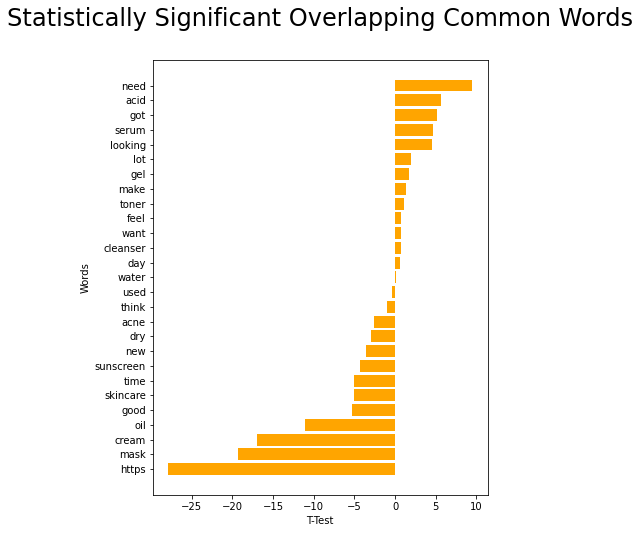

In [24]:
plt.figure(figsize=(6,8))
plt.barh(overlap_stats.index.values,
         overlap_stats['Statistic'].sort_values(),
        color='orange')

plt.title('Statistically Significant Overlapping Common Words\n', fontsize=24)
plt.xlabel('T-Test')
plt.ylabel('Words');

plt.savefig('../plots/overlap_words.png', dpi=235, bbox_inches='tight')

## Save engineered data to .csv
---

In [25]:
df.to_csv('../data/explored_skincare.csv', index=False)